## Sparse flight data

A key question for the generation of sparse state networks is _how_ sparse. If we lump all state nodes with each physical node, we loose all higher-order information and may underfit. On the other hand, keeping all second-order state nodes may overfit.

Here we will generate multiple sparse networks with different number of (lumped) state nodes and evaluate the result with Infomap

### Generate training and validation sets
To get a bigger network, merge the flight path data from the four quarters. But to evaluate the goodness of fit, split each path randomly in either a _training_ or a _validation_ set and write a path data file for each of the data set.

In [1]:
from random import random

In [2]:
def generateData(inputFilenames):
    """Merge path data from inputFilenames and write to two path data files
    for training and validation. Each path in the input data is selected by
    random to be written to either the training or validation data file"""
    data = { 'training': [], 'validation': [] }
    # Read path data
    for filename in inputFilenames:
        print("Parsing paths from '{}'...".format(filename))
        with open(filename, mode='r') as infile:
            # Skip heading
            next(infile)
            for row in infile:
                if random() < 0.5:
                    data['validation'].append(row)
                else:
                    data['training'].append(row)
    # Write path data
    for name, paths in data.items():
        outFilename = "../output/paths_{}.net".format(name)
        print("Writing {} paths to {}...".format(len(paths), outFilename))
        with open(outFilename, mode='w') as outfile:
            outfile.write("*paths\n")
            for p in paths:
                outfile.write(p)

In [3]:
inputFilenames = ["../data/air2015_{}_paths.net".format(quarter) for quarter in [1,2,3,4]]
generateData(inputFilenames)

Parsing paths from '../data/air2015_1_paths.net'...
Parsing paths from '../data/air2015_2_paths.net'...
Parsing paths from '../data/air2015_3_paths.net'...
Parsing paths from '../data/air2015_4_paths.net'...
Writing 33397 paths to ../output/paths_training.net...
Writing 33628 paths to ../output/paths_validation.net...


#### Generate state networks from paths

In [4]:
import infomap

In [5]:
def generateStateNetworkFromPaths(inputFilename, outputFilename, markovOrder):
    network = infomap.Network(infomap.Config("--directed --path-markov-order {}".format(markovOrder)))
    network.readInputData(inputFilename)
    network.writeStateNetwork(outputFilename)

In [6]:
generateStateNetworkFromPaths("../output/paths_training.net", "../output/states_training_order_2.net", 2)
generateStateNetworkFromPaths("../output/paths_validation.net", "../output/states_validation_order_2.net", 2)

### Generate _sparse_ state networks

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from state_lumping_network import StateNetwork

In [8]:
sparseNet = StateNetwork()
sparseNet.readFromFile("../output/states_training_order_2.net")

Read state network from file '../output/states_training_order_2.net'...
 -> StateNetwork (1977 physical nodes, 15924 state nodes and 44867 links)


In [9]:
h0 = sparseNet.calcEntropyRate()
print("Original average entropy rate:", h0)

Original average entropy rate: 3.7389056651248334


In [10]:
clusterRates = np.linspace(0.1, 1, 10)
# clusterRates = [0.25, 0.5, 0.75]
# clusterRates = [0.5]
numStates = []
entropyRate = []

for i, clusterRate in enumerate(clusterRates):
    sparseNet.clusterStateNodes(clusterRate=clusterRate)
    s = sparseNet.numLumpedStateNodes()
    h = sparseNet.calcLumpedEntropyRate()
    sparseNet.writeLumpedStateNetwork("../output/states_training_lumped_{}.net".format(i))
    numStates.append(s)
    entropyRate.append(h)

Cluster state nodes...
Generate lumped state network from clustering...
 -> 2276 state nodes and 17875 links in lumped network.
Writing lumped state network to file '../output/states_training_lumped_0.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 2715 state nodes and 22400 links in lumped network.
Writing lumped state network to file '../output/states_training_lumped_1.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 3177 state nodes and 26026 links in lumped network.
Writing lumped state network to file '../output/states_training_lumped_2.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 3672 state nodes and 29315 links in lumped network.
Writing lumped state network to file '../output/states_training_lumped_3.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 4197 state nodes and 31898 links in lumped network.
Writing lumped state network to file

#### How much information do we loose as we reduce the number of state nodes?

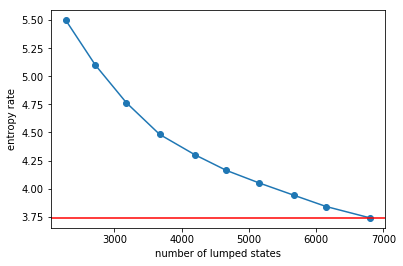

In [17]:
plt.plot(numStates, entropyRate, marker='o')
plt.xlabel("number of lumped states")
plt.ylabel("entropy rate")
plt.axhline(y=h0, color='r', linestyle='-')
# plt.axvline(x=sparseNet.numStateNodes(), color='r')
plt.show()

Note that the original number of state nodes (close to 16k) is much more than the maximum in the lumped state networks. This gap is due to the existence of dangling nodes wich are lumped implicitly.

### Validate with Infomap
The goal here is to calculate the codelength for the validation network, given the different partitions found on the lumped training networks.

In [12]:
def partition(inputFilename):
    im = infomap.Infomap("--directed")
    im.network().readInputData(inputFilename)
    im.run()
    print(" -> Found {} top modules with codelength {}".format(im.numTopModules(), im.codelength()))


In [13]:
partition("../output/states_training_order_2.net")

 -> Found 34 top modules with codelength 8.393094071847125


In [14]:
partition("../output/states_validation_order_2.net")

 -> Found 34 top modules with codelength 8.386110701045006


In [15]:
partition("../output/states_training_lumped_0.net")

 -> Found 8 top modules with codelength 7.477414824081122


In [16]:
partition("../output/states_training_lumped_9.net")

 -> Found 59 top modules with codelength 8.271783210227138
